In [1]:
#Import Library
import numpy as np
import pandas as pd
import pydot
import uuid

In [16]:
#Load data
eps = np.finfo(float).eps

df = pd.read_csv('/content/data_forecast1.csv')
# df = pd.read_csv('/content/data_gold.csv')
print('Data:\n',df)



Data:
      Outlook Temperature Humidity   Windy        Play
0      sunny         hot     high    weak  don't play
1      sunny         hot     high  strong  don't play
2   overcast         hot     high    weak        play
3       rain        mild     high    weak        play
4       rain        cold   normal    weak        play
5       rain        cold   normal  strong  don't play
6   overcast        cold   normal  strong        play
7      sunny        mild     high    weak  don't play
8      sunny        cold   normal    weak        play
9       rain        mild   normal    weak        play
10     sunny        mild   normal  strong        play
11  overcast        mild     high    weak        play
12  overcast         hot   normal    weak        play
13      rain        mild     high  strong  don't play
14  overcast        mild     high  strong  don't play


In [18]:
#Find the Entropy of whole dataset
def find_entropy(df):
    Class = df.keys()[-1]
    entropy = 0
    values = df[Class].unique()
    # print("values la: ", values)
    for value in values:
        fraction = df[Class].value_counts()[value]/len(df[Class])
        entropy += -fraction*np.log2(fraction) # -(play/tong)*log2(play/tong)+ -(don't play/tong)*log2(dont' play/tong)
    return entropy

In [19]:
#Define a function to calculate entropy of each attribute
def find_entropy_attribute(df,attribute):
    Class = df.keys()[-1]
    target_variables = df[Class].unique()  #This gives all 'Play' and 'Don't Play
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[Class] ==target_variable]) #Numerator
            den = len(df[attribute][df[attribute]==variable]) #Denominator
            fraction = num/(den+eps)
            entropy += -fraction*np.log2(fraction+eps)
        fraction2 = den/len(df)
        entropy2 += -fraction2*entropy
    return (abs(entropy2))

In [5]:
#Calculate Information Gain each attributes function
def ig(e_dataset,e_attr):
    return(e_dataset-e_attr)

In [6]:
#Find attribute which has maximum IG
def find_winner(df):
    IG = []
    for key in df.keys()[:-1]:
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    max = df.keys()[:-1][np.argmax(IG)]
    return max

In [7]:
#Function to get sub attribute of node
def get_subtable(df, node,value):
    return df[df[node] == value].reset_index(drop=True)

In [20]:
#Build a decition tree
def buildTree(df,tree=None): 
    Class = df.keys()[-1]
    #Get attribute with maximum information gain
    node = find_winner(df)
    # node_root_temp =[]
    # node_root_temp.append(find_winner(df)) 
    attValue = np.unique(df[node])
    #Create an empty dictionary to create tree    
    if tree is None:                    
        tree={}
        tree[node] = {}
    #Make loop to construct a tree by calling this function recursively. 
    #Check if the subset is pure and stops if it is pure. 
    for value in attValue:
        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable[Class],return_counts=True)                        
        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]                                                    
        else:
            tree[node][value] = buildTree(subtable) #Calling the function recursively   
            
    return tree

In [22]:
#Print report and prediction base on decision tree
print("\n\nGiá Trị của Entropy_node", df.keys()[-1], "là:",find_entropy(df),"\n")
a_entropy2 = {k:find_entropy_attribute(df,k) for k in df.keys()[:-1]}
print("Entropy cua tung attribute la: ",a_entropy2,"\n")
IG = {k:ig(find_entropy(df),a_entropy2[k]) for k in a_entropy2}
print("Information Gain cua tung attribute là" , IG,"\n")
print("\n") 

t = buildTree(df)
import pprint
pprint.pprint(t)
print("\n")

#Write result to txt file
f = open("resultID3_v2.txt", "w")
f.write(str(f'entropy_node la: \n'))
f.write(str(find_entropy(df)))
f.write("\n\n")
f.write("Entropy cua tung attribute la: \n")
f.write(str(a_entropy2))
f.write("\n\n")
f.write("Information Gain là: \n")
f.write(str(IG))
f.write("\n\n")
f.write("Tree: \n")
f.write(str(t))
f.write("\n\n")
f.close()



Giá Trị của Entropy_node Play là: 0.9709505944546686 

Entropy cua tung attribute la:  {'Outlook': 0.8879430945988993, 'Temperature': 0.9427806300050855, 'Humidity': 0.7851454315650669, 'Windy': 0.8258410375269674} 

Information Gain cua tung attribute là {'Outlook': 0.08300749985576927, 'Temperature': 0.028169964449583085, 'Humidity': 0.1858051628896017, 'Windy': 0.14510955692770122} 



{'Humidity': {'high': {'Outlook': {'overcast': {'Windy': {'strong': "don't "
                                                                    'play',
                                                          'weak': 'play'}},
                                   'rain': {'Windy': {'strong': "don't play",
                                                      'weak': 'play'}},
                                   'sunny': "don't play"}},
              'normal': {'Outlook': {'overcast': 'play',
                                     'rain': {'Windy': {'strong': "don't play",
                              

In [23]:
#Draw a decíion tree as file png
import pydot
import uuid

def generate_unique_node():
    """ Generate a unique node label."""
    return str(uuid.uuid1())

def create_node(graph, label, shape='oval'):
    node = pydot.Node(generate_unique_node(), label=label, shape=shape)
    graph.add_node(node)
    return node

def create_edge(graph, node_parent, node_child, label):
    link = pydot.Edge(node_parent, node_child, label=label)
    graph.add_edge(link)
    return link

def walk_tree(graph, dictionary, prev_node=None):
    """ Recursive construction of a decision tree stored as a dictionary """
    for parent, child in dictionary.items():
        # root
        if not prev_node: 
            root = create_node(graph, parent)
            walk_tree(graph, child, root)
            continue
            
        # node
        if isinstance(child, dict):
            for p, c in child.items():
                n = create_node(graph, p)
                create_edge(graph, prev_node, n, str(parent))
                walk_tree(graph, c, n)
    
        # leaf
        else: 
            leaf = create_node(graph, str(child), shape='box')
            create_edge(graph, prev_node, leaf, str(parent))

# def plot_tree(dictionary, filename="DecisionTree.png"):
#     graph = pydot.Dot(graph_type='graph')
#     walk_tree(graph, tree)
#     graph.write_png(filename)
        

tree = dt2 = buildTree(df)
# plot_tree(tree)
graph = pydot.Dot(graph_type='digraph')
walk_tree(graph, tree)

graph.write_png("DecisionTree_ID3.png")
# print(type())

Org image shape -->  (407, 769, 3)


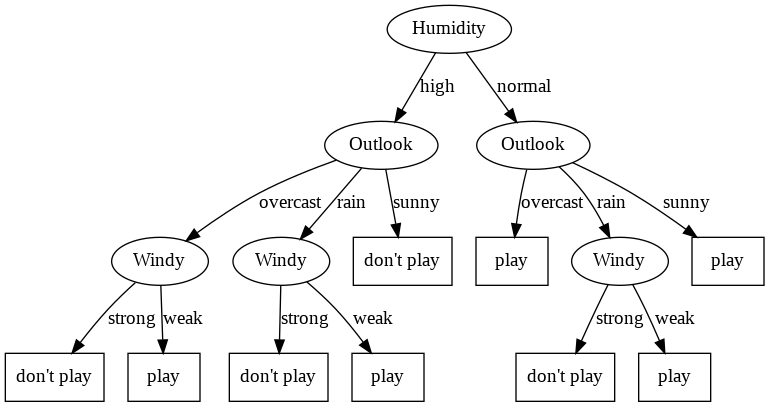

In [24]:
import cv2
from google.colab.patches import cv2_imshow # for image display
clusters = 5 # try changing it

path="/content/DecisionTree_ID3.png"
img = cv2.imread(path, 1)
org_img = img
print('Org image shape --> ',img.shape)
cv2_imshow(img)
cv2.destroyAllWindows()

In [25]:
#Prediction######################################################################################################
dt2 = buildTree(df)
df2 = pd.DataFrame(data=[['rain', 'hot', 'high', 'strong']],columns=['Outlook', 'Temperature', 'Humidity', 'Windy'])
# df2 = pd.DataFrame(data=[['CAO', 'ON DINH', 'THAP', 'THAP']],columns=['USD', 'Inflat (CPI)', 'Quantity Supply', 'Quantity exploit'])

def fun(d, t):
    """
    d -- decision tree dictionary
    t -- testing examples in form of pandas dataframe
    """
    res = []
    for _, e in t.iterrows():
        res.append(predict(d, e))
    return res

def predict(d, e):
    """
    d -- decision tree dictionary
    e -- a testing example in form of pandas series
    """
    current_node = list(d.keys())[0]
    current_branch = d[current_node][e[current_node]]
    # if leaf node value is string then its a decision
    if isinstance(current_branch, str):
        return current_branch
    # else use that node as new searching subtree
    else:
        return predict(current_branch, e)

print("Dự đoán quyết định của một điều kiện thời tiết: \n",df2 ,"\n\n Kết quả dự đoán là:",fun(dt2, df2))

Dự đoán quyết định của một điều kiện thời tiết: 
   Outlook Temperature Humidity   Windy
0    rain         hot     high  strong 

 Kết quả dự đoán là: ["don't play"]
